In [1]:
import sys
sys.path.append("/global/u2/r/ritesh11/GSOC_2025/")

In [2]:
import numpy as np
import re
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt

from Flash.tokenizer import Tokenizer
from Flash.constants import SPECIAL_SYMBOLS, PAD_IDX, UNK_IDX, T_IDX, BOS_IDX, EOS_IDX, SEP_IDX

In [27]:
df = pd.read_csv("/pscratch/sd/r/ritesh11/EW/data/EW_2-2-3_cutofftest.csv")
res_dir = "/pscratch/sd/r/ritesh11/EW/data/EW_2-2-3_cutoff_termwisetest.csv"

In [3]:
tokenizer = Tokenizer(df,300,SPECIAL_SYMBOLS,UNK_IDX,False)

NameError: name 'df' is not defined

In [29]:
def split_expression(expr: str) -> list:
    terms = []
    current = []
    depth = 0
    i = 0
    while i < len(expr):
        char = expr[i]

        if char == '(':
            depth += 1
            current.append(char)
        elif char == ')':
            depth -= 1
            current.append(char)
        elif char in '+-' and depth == 0:
            if current:
                terms.append(''.join(current).strip())
                current = [char] if char == '-' else []
            else:
                current.append(char)  
        else:
            current.append(char)
        i += 1

    if current:
        terms.append(''.join(current).strip())

    return [term for term in terms if term]

In [30]:
exps = []
for sqamp in tqdm(df.sqamp.tolist()):
    temp = [e for e in split_expression(sqamp)]
    exps.append(temp)

100%|██████████| 28456/28456 [00:04<00:00, 6866.96it/s]


In [31]:
for exp in tqdm(exps):
    for i in range(len(exp)):
        if i==0:
            if(len(exp) == 1):
                exp[i] = SPECIAL_SYMBOLS[BOS_IDX] + exp[i] + SPECIAL_SYMBOLS[EOS_IDX]
            else:
                exp[i] = SPECIAL_SYMBOLS[BOS_IDX] + exp[i] + SPECIAL_SYMBOLS[SEP_IDX]
        elif i==len(exp)-1:
            exp[i] = SPECIAL_SYMBOLS[T_IDX[i]] + exp[i] + SPECIAL_SYMBOLS[EOS_IDX]
        else:
            exp[i] = SPECIAL_SYMBOLS[T_IDX[i]] + exp[i] + SPECIAL_SYMBOLS[SEP_IDX]

100%|██████████| 28456/28456 [00:00<00:00, 561754.24it/s]


In [32]:
amps = df.amp.tolist()
prs = df.process.tolist()

In [33]:
data = {"amp":[], "sqamp":[], 'process': []}

In [34]:
for a,sqa,p in zip(amps,exps,prs):
    for e in sqa:
        data['amp'].append(a)
        data['sqamp'].append(e)
        data['process'].append(p)

In [35]:
df_new = pd.DataFrame(data)

In [36]:
df_new.sqamp[1234]

'<BOS>1/4*e^2*MOMENTUM_13*MOMENTUM_24*(m_e^2+-1/2*m_W3^2+MOMENTUM_12+1/2*reg_prop)^(-2)*cos(theta_W)^(-2)*sin(theta_W)^2*(e*sin(theta_W)/cos(theta_W)+-e*cos(theta_W)/sin(theta_W))^2<EOS>'

In [37]:
df_new.to_csv(res_dir,index=False)

In [5]:
df_train = pd.read_csv("/pscratch/sd/r/ritesh11/EW/data/EW_2-2-3train.csv")
df_valid = pd.read_csv("/pscratch/sd/r/ritesh11/EW/data/EW_2-2-3valid.csv")
df_test = pd.read_csv("/pscratch/sd/r/ritesh11/EW/data/EW_2-2-3test.csv")
df = pd.concat([df_train,df_valid,df_test])

In [6]:
tokenizer = Tokenizer(df,100,SPECIAL_SYMBOLS,UNK_IDX,False)

In [7]:
amps = df.amp
sqamps = df.sqamp

In [8]:
src_arr = []
tgt_arr = []
for a,s in tqdm(zip(amps,sqamps), total=len(amps)):
    src_arr.append(len(tokenizer.src_tokenize(a)))
    tgt_arr.append(len(tokenizer.tgt_tokenize(s)))

100%|██████████| 261284/261284 [01:52<00:00, 2315.72it/s]


In [9]:
src_arr = np.array(src_arr)
tgt_arr = np.array(tgt_arr)

In [10]:
import matplotlib.pyplot as plt

In [11]:
src_arr.mean(), tgt_arr.mean()

(np.float64(332.7509874313008), np.float64(719.0188683578023))

In [12]:
src_arr.max(), tgt_arr.max()

(np.int64(799), np.int64(2800))

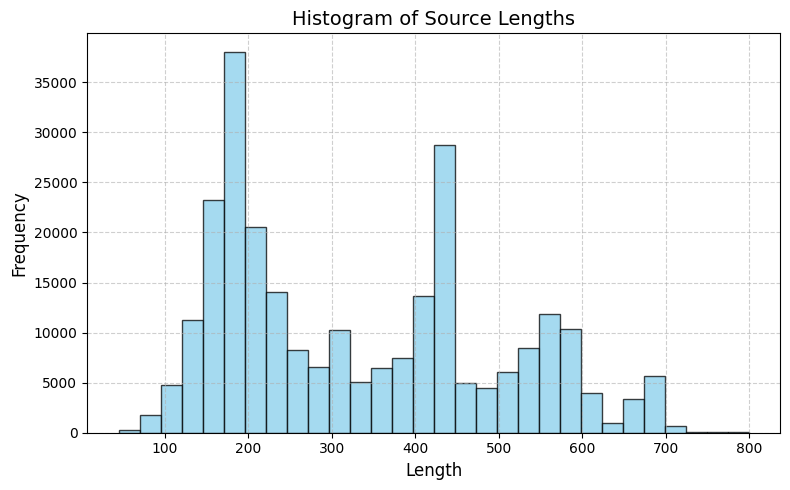

In [13]:
plt.figure(figsize=(8, 5))  # Set figure size

plt.hist(src_arr, bins=30, color='skyblue', edgecolor='black', alpha=0.75)

plt.title("Histogram of Source Lengths", fontsize=14)
plt.xlabel("Length", fontsize=12)
plt.ylabel("Frequency", fontsize=12)

plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()  # Adjust layout to fit labels
plt.show()

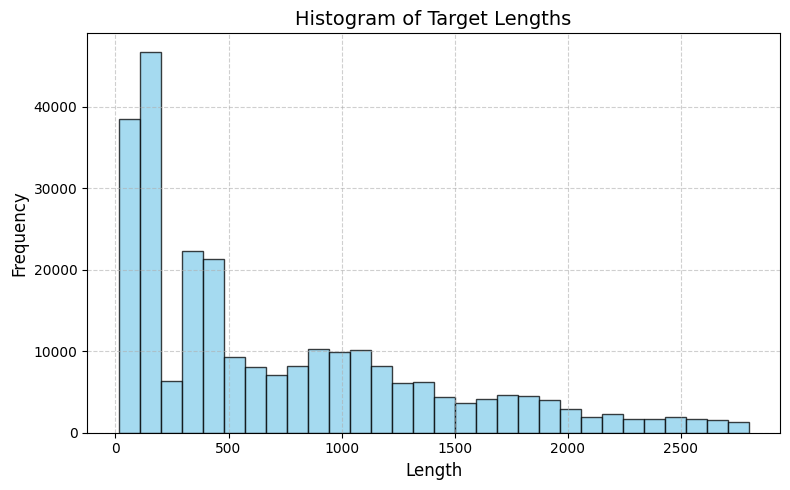

In [14]:
plt.figure(figsize=(8, 5))  # Set figure size

plt.hist(tgt_arr, bins=30, color='skyblue', edgecolor='black', alpha=0.75)

plt.title("Histogram of Target Lengths", fontsize=14)
plt.xlabel("Length", fontsize=12)
plt.ylabel("Frequency", fontsize=12)

plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()  # Adjust layout to fit labels
plt.show()

In [21]:
(tgt_arr > 800).sum()

np.int64(2288)